In [1]:
# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# py3helpers
from py3helpers.utils import merge_lists, list_dir
# signalalign
from signalalign.fast5 import Fast5
from signalalign.hiddenMarkovModel import read_in_alignment_file

# Other common libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
# built in library
import os


In [2]:
prp43_path = "figures/event_clustering/20210619_R941_prp43"
wt_path = "figures/event_clustering/20210410_R941_WT_YPD"
prp43_files = list_dir(prp43_path, ext="tsv")
wt_files = list_dir(wt_path, ext="tsv")

In [3]:
def get_25S_events(files, start, stop):
    all_events = []
    for file1 in files:
        try:
            data = read_in_alignment_file(file1)
        except:
            continue
        if np.sum(data["contig"] == "RDN25-1") > 0:
            events = []
            for x in range(start, stop):
                pos_data = data[data["reference_index"] == x]
                if len(pos_data) > 0:
                    index = data[data["reference_index"] == x].posterior_probability.idxmax()
                    events.append(data.loc[index]["descaled_event_mean"])
                else:
                    break
            if len(events) == stop-start:
                all_events.append(events)
    return pd.DataFrame(all_events, columns=list(range(start+1, stop+1)))

In [6]:
start = 1430
stop = 1455
prp43_df = get_25S_events(prp43_files, start=start, stop=stop)
wt_df = get_25S_events(wt_files, start=start, stop=stop)

In [7]:
prp43_df["label"] = "prp43"
wt_df["label"] = "wt"
df = pd.concat([wt_df, prp43_df], ignore_index=True)
X = df.loc[:, df.columns != 'label']


In [8]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)

/Users/andrewbailey/anaconda3/envs/signalalign/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


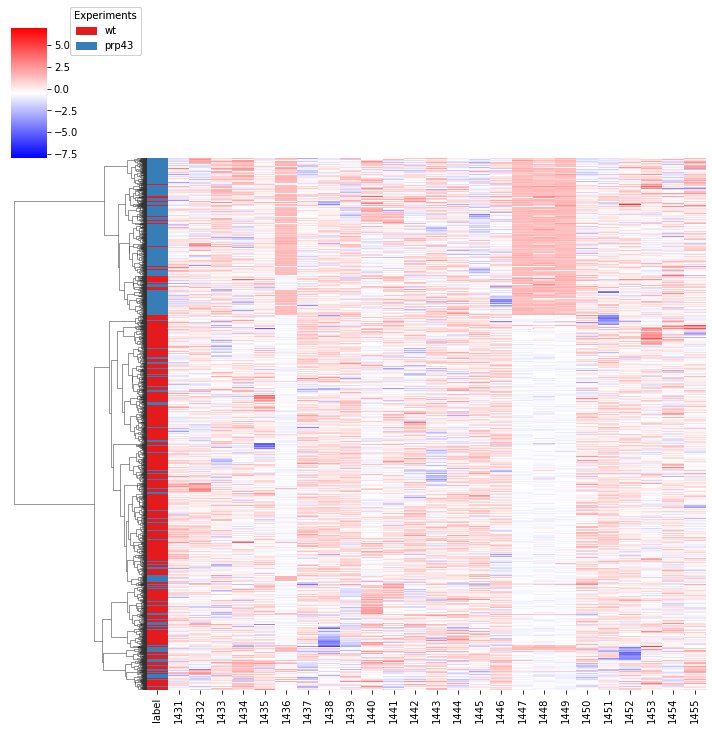

In [9]:
color_map = dict(zip(["wt", "prp43"], sns.color_palette("Set1")))
row_colors = pd.DataFrame(df["label"].map(color_map))
figure_path = 'figures/event_clustering/event_clustering.png'
g = sns.clustermap(scaled_X, method="ward", metric="euclidean", col_cluster=False,
                   row_cluster=True, row_colors=row_colors,
                   yticklabels=False, xticklabels=True, cmap="bwr", figsize=(10,10))

experiment_labels = []
for experiment, color in color_map.items():
    red_patch = mpatches.Patch(color=color, label=experiment)
    experiment_labels.append(red_patch)

# red_pseudoU = mpatches.Patch(color="red", label="Pseudouridine")
# blue_twoprime = mpatches.Patch(color="blue", label="2'O methylcytosine")

first_legend = plt.legend(handles=experiment_labels, bbox_to_anchor=(1.5, 1.2), loc='upper left', ncol=1,
                          title="Experiments")
plt.gca().add_artist(first_legend)

if figure_path is not None:
    plt.savefig(figure_path, dpi=1000)
else:
    plt.show()
